# 0.0 IMPORTS 

In [1]:
import numpy      as np
import pandas     as pd
import seaborn    as sns
import re
import sqlalchemy

import sqlite3
import umap.umap_ as umap

from matplotlib import pyplot       as plt
from sklearn import cluster         as c
from sklearn import metrics         as m 
from sklearn import ensemble        as en
from sklearn import preprocessing   as pp
from sklearn import decomposition   as dd
from sklearn import manifold        as mn
from sklearn import mixture         as mx 
from scipy.cluster import hierarchy as hc 
from sklearn import mixture         as mx
from plotly import express          as px
from sklearn.mixture import GaussianMixture
from datetime import datetime
from sqlalchemy import create_engine
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


/home/leticia/anaconda3/envs/pa05/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/leticia/anaconda3/envs/pa05/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/leticia/anaconda3/envs/pa05/lib/python3.11/site-packages/umap/dist

## 0.2 Load dataset

In [2]:
#load date

#caminho 
path='/home/leticia/Documentos/comunidade_ds/pa_05/src/'
df_raw = pd.read_csv(path +'data/Ecommerce.csv', encoding='latin-1')

#drop extra column
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)

#vizualização
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 Descrição dos Dados 


In [4]:
df1=df_raw.copy()

## 1.1 Rename Columuns

In [5]:
# Saber o nome das colunas 
df1.columns

#mudando nome das colunas 
cols_new =['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']

df1.columns= cols_new


## 1.2 Data dimensions 

In [6]:
# Saber o tamanho do meu dataset
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of cols: {df1.shape[1]}')

Number of rows: 541909
Number of cols: 8


## 1.3 Data Types 

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA 

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA 

In [9]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [10]:
#criando referencia 
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id']=np.arange(1900, 1900+len(df_backup), 1)

#merge original with reference dataframe    
df1=pd.merge(df1, df_backup, on='invoice_no', how='left' )

#coalace( uma função para juntar as duas colunas em uma só )
df1['customer_id']= df1['customer_id_x'].combine_first(df1['customer_id_y'])

df1=df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)


In [11]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change dtypes 

In [12]:
#invoice date
#Tranformando a colunas da data em formato de data 'invoice_date' 
df1['invoice_date'] = pd.to_datetime (df1['invoice_date'], format= '%d-%b-%y')

#customer id 
# Transformando o 'customer_id ' para numeros inteiros
df1['customer_id']= df1['customer_id']. astype(int)
df1.head()


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [13]:
#mudança de tipo 
df1.dtypes


invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7 Descriptive Statistics

In [14]:
num_atributes= df1.select_dtypes(include=['int64','float64'])
cat_atributes= df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Numerical Attributs

In [15]:
# CENTRAL TENDENCY -mean , median 
ct1 = pd.DataFrame( num_atributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_atributes.apply( np.median ) ).T

#DISPERSION - desvio padrão, minimo, maximo, range,skew,kurtosis
d1 = pd.DataFrame( num_atributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_atributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_atributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_atributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_atributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_atributes.apply( lambda x: x.kurtosis() ) ).T


#Concatenate
m1 = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m1.columns = ['attributes','min','max','range','mean','mediana','std','skew','kurtosis']
m1

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,1900.00,18287.0,16387.00,12426.375722,14382.00,5217.395870,-0.930929,-0.694653


### 1.7.2 Categorical Attributs

#### invoice number 

In [16]:
#invoice number( é o numero do carrinho ) 
#temos invoce com letras e numeros , tentei transformar para numero inteiro e]
#não deu certo pois tem letras junto com os numeros 
# procurandouma linha que tem pelo menos uma letra 
#drop as colunas repitidas

df_letter_invoices = df1.loc[df1['invoice_no'].apply (lambda x: bool(re.search('[^0-9]+', x ) ) ), :]
df_letter_invoices.head()

print( 'Total number of invoices:{}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity:{}'.format( len( df_letter_invoices[ df_letter_invoices['quantity']< 0 ] ) ) )

# observamos que a quantidade de invoces com as quantidades são negativas , então todos os envoices que possui a letra C
# é negativa pode ser considerada uma devolução que não é tao importante para o que estamos analisando 


Total number of invoices:9291
Total number of negative quantity:9288


#### stock_code

In [17]:
#Quantos tipos ey tenho 
df1.loc[df1['stock_code'].apply(lambda x: bool( re.search( '^[a-zA-z]+$', x ) ) ), 'stock_code'].unique()

#Ação 
## Remover stock_code in (['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'])

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

# 2.0 Filtagem de Variáveis 

In [18]:

df2=df1.copy()

In [19]:
#========NUMECAL ATTRIBUTES=========#
#quando olharmos o preço dos produtos vamos encontrar produtos igual a zero , podemos classificar ele como brindes

df2=df2.loc[df2['unit_price'] >= 0.04, :]


#============ Categorica attributes =======#
df2=df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK'])]


#============ Description =================#

df2 = df2.drop( columns='description', axis=1 )

#map

df2=df2[~df2['country'].isin(['European Community','Unspecified'])]

#bad user
df2=df2[~df2['customer_id'].isin( [16446] )]

# quantity
df2_returns= df2.loc[df1['quantity'] < 0, : ]
df2_puchases = df2.loc[df1['quantity'] >= 0,: ]



# 3.0 Featuture Engineering

In [20]:
df3=df2.copy()

## 3.1. Feature Creation

In [21]:
#data reference 
df_ref = df3.drop( ['invoice_no','stock_code','quantity','invoice_date','unit_price','country'], axis=1 ).drop_duplicates(ignore_index=True)

### 3.1.1. Gross Revenue

In [22]:
#Gross Revenue( faturamento ) quantiade * preço 
df2_puchases.loc[:, 'gross_revenue'] = df2_puchases.loc[:, 'quantity'] * df2_puchases.loc[:,'unit_price']

# Monetary 
df2_monetary = df2_puchases.loc[:,['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df2_monetary, on='customer_id', how='left')
df_ref.isna().sum()

/tmp/ipykernel_3879/2403498641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_puchases.loc[:, 'gross_revenue'] = df2_puchases.loc[:, 'quantity'] * df2_puchases.loc[:,'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency -Day from last puchase 

In [23]:
# Recency - Last puschase 
df_recency = df2_puchases.loc[:,['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref= pd.merge( df_ref , df_recency,on='customer_id', how= 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.6 Quantity of products puchased

In [24]:
df_freq = df2_puchases.loc[:,['customer_id', 'stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code':'qtde_products'})
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how= 'left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
dtype: int64

### 3.1.8.Frequency Purchase


In [25]:
df_aux = ( df2_puchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                                      .groupby( 'customer_id')
                                                                      .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                            min_ = ( 'invoice_date', 'min' ),
                                                                            days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                            buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
frequency        91
dtype: int64

### 3.2.0 Number of Returns

In [26]:
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
frequency        91
qtde_returns      0
dtype: int64

# 4.0 EDA ( Exploratory Data Analysis)

 - Para realizar a Analise explanatoria de daos temos que fazer analise juncom os clusteres cliados com a tabela final. 
 - Comprovando as hipoteses criada pelo time de negocio atraves de analise de dados;

In [27]:
df4= df_ref.dropna()
df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
qtde_products    0
frequency        0
qtde_returns     0
dtype: int64

## 4.3 Estudo do espaço 

In [28]:

#Select features Dataset
cols_selected = ['customer_id','gross_revenue','recency_days','qtde_products','frequency','qtde_returns']
df43 = df4[cols_selected].drop(columns='customer_id',axis=1 )


In [29]:
df43.head()

,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
0,5391.21,372.0,297.0,17.000000,40.0
1,3232.59,56.0,171.0,0.028302,35.0
2,6705.38,2.0,232.0,0.040323,50.0
3,948.25,95.0,28.0,0.017921,0.0
4,876.00,333.0,3.0,0.073171,22.0


In [30]:
mm=pp.MinMaxScaler()

df43['gross_revenue']                  = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days']                   = mm.fit_transform(df43[['recency_days']])
df43['qtde_products']                  = mm.fit_transform(df43[['qtde_products']])
df43['frequency']                      = mm.fit_transform(df43[['frequency']])
df43['qtde_returns']                   = mm.fit_transform(df43[['qtde_returns']])
X=df43.copy()

In [31]:
X.shape    

(5695, 5)

### 4.3.1 PCA

In [32]:
X.shape[1]

5

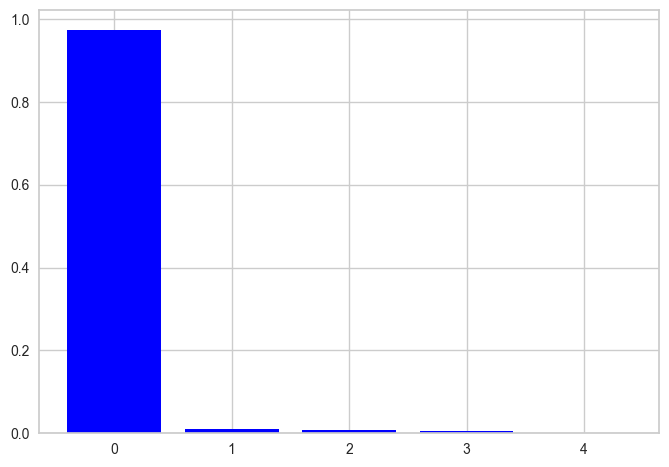

In [33]:
pca= dd.PCA(n_components=X.shape[1])
principal_components =pca.fit_transform(X)

#plot explained variable
features= range(pca.n_components_)

plt.bar(features,pca.explained_variance_ratio_, color='blue')

#pca component
df_pca = pd.DataFrame(principal_components)

<Axes: xlabel='0', ylabel='1'>

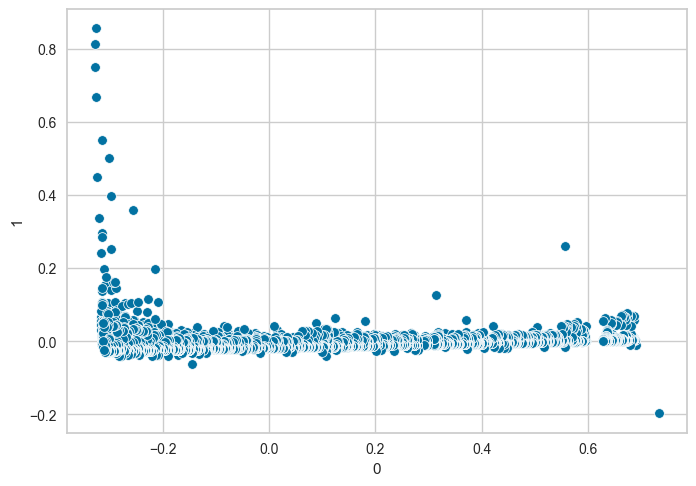

In [34]:
sns.scatterplot(x=0, y=1 ,data=df_pca)

In [35]:
df_pca.head()

,0,1,2,3,4
0,0.732400,-0.197687,0.910736,0.028364,0.000060
1,-0.164889,0.012960,-0.019425,0.002792,0.000127
2,-0.309663,0.022149,-0.008462,-0.000287,-0.001001
3,-0.060153,-0.001517,-0.029344,-0.004605,-0.000494
4,0.577166,0.015246,-0.055749,-0.005013,-0.001334


### 4.3.2 UMAP

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

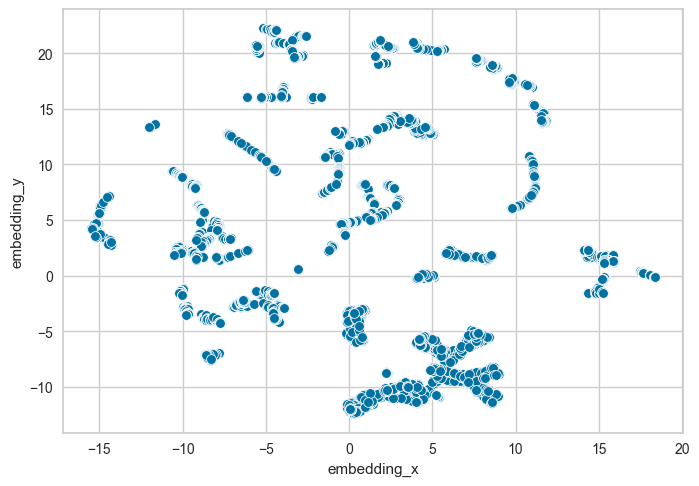

In [36]:
reducer = umap.UMAP( random_state= 42 )
embedding =reducer.fit_transform( X )

#embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:,0]
df_umap['embedding_y'] = embedding[:,1]

#plot UMAP

sns.scatterplot( x='embedding_x', 
                 y='embedding_y',           
                 data=df_umap)







### 4.3.3 t-SNE

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

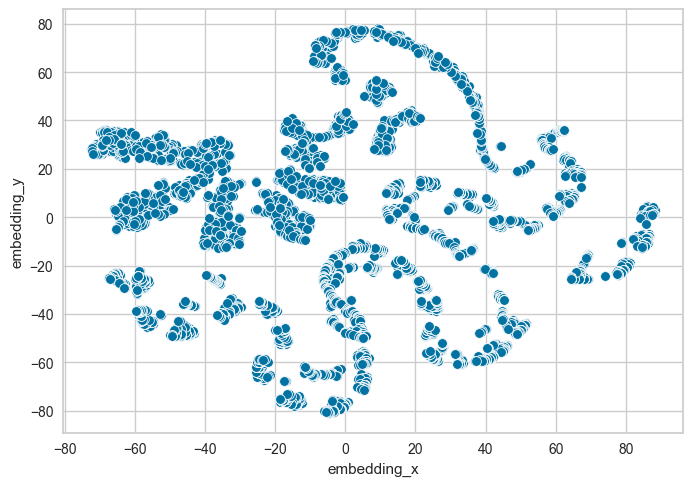

In [37]:
reducer = mn.TSNE( n_components=2,n_jobs=-1, random_state= 42 )
embedding =reducer.fit_transform( X )

#embedding
df_tsne= pd.DataFrame()
df_tsne['embedding_x'] = embedding[:,0]
df_tsne ['embedding_y'] = embedding[:,1]

#plot UMAP

sns.scatterplot( x='embedding_x', 
                 y='embedding_y',           
                 data=df_tsne )


### 4.3.3 Tree-Based Embedding

In [38]:
#training dataset
X= df43.drop(columns=['gross_revenue'],axis=1)
y= df43['gross_revenue']

#model definition
rf_model= en.RandomForestRegressor(n_estimators=100, random_state=42)

#model training
rf_model.fit(X,y)


RandomForestRegressor(random_state=42)

In [39]:
#Leaf
df_leaf= pd.DataFrame(rf_model.apply(X))

/home/leticia/anaconda3/envs/pa05/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

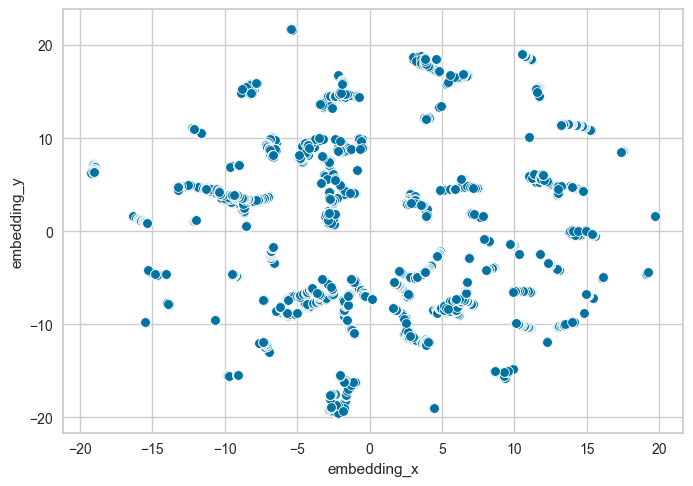

In [40]:
reducer = umap.UMAP( random_state= 42 )
embedding =reducer.fit_transform( df_leaf )

#embedding
dr_tree =pd.DataFrame()
dr_tree['embedding_x'] = embedding[:,0]
dr_tree['embedding_y'] = embedding[:,1]

#plot UMAP

sns.scatterplot( x='embedding_x', 
                 y='embedding_y',           
                 data=dr_tree)

# 5.0 Data Preparation

In [41]:
# #Tree-Based Embedding 
# df5 =dr_tree.copy()

#UMAP Embedding
df5= df_umap.copy()
df5.to_csv(path+'data/umap_embedding.csv', index= False)

# #TSNE Embedding
# df5 = df_tsne.copy()  

# 7.0 Hyperparameter Fine-tunning

In [42]:
X = df5.copy()

In [43]:
X.head()

,embedding_x,embedding_y
0,14.938428,1.620200
1,6.812539,1.688329
2,0.178182,-5.775623
3,-15.290986,4.625461
4,10.784216,10.759123


In [44]:
# clusters= [2,3,4,5,6,7,8,9]
clusters = np.arange(2,25,1)
for k in clusters:
    print(k)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


## 7.1 K-Means  

In [45]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model =c.KMeans( n_clusters= k, n_init=100, random_state=42 )
        
    # #model training
    kmeans_model.fit( X ) 

    # #model predict
    labels = kmeans_model.predict( X ) 

    # #model performece
    sil = m.silhouette_score   (X, labels, metric='euclidean')
    kmeans_list.append(sil)
  


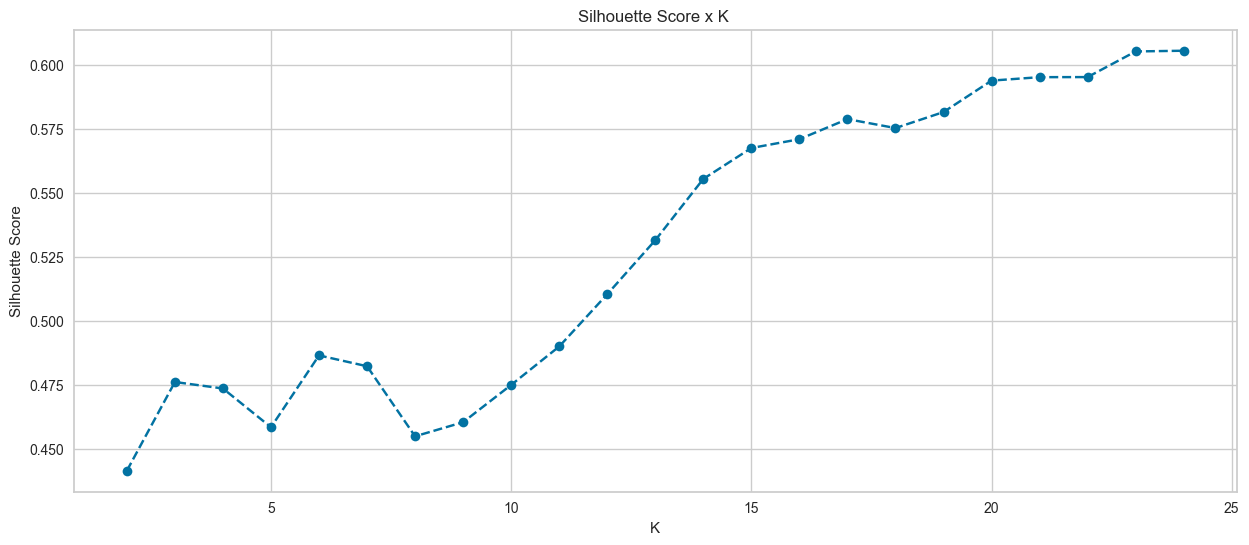

In [46]:
plt.plot(clusters,kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title ('Silhouette Score x K ')
plt.gcf().set_size_inches(15, 6)

## 7.2.GMM

In [47]:
gmm_list=[]
for k in clusters:
    #model definition
    gmm_model =mx.GaussianMixture(n_components=k, n_init=100, random_state=42)

    #model training 
    gmm_model.fit(X)
    #model predict 
    labels = gmm_model.predict(X)

    #model performece
    sil=m.silhouette_score(X, labels, metric = 'euclidean') 
    gmm_list.append(sil)

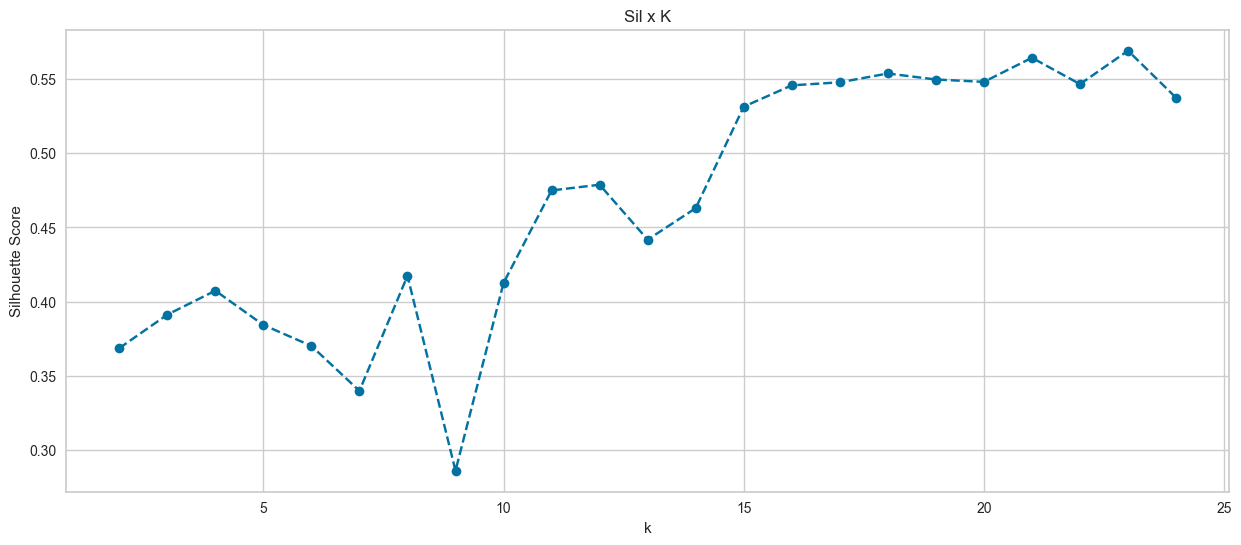

In [48]:
plt.plot(clusters, gmm_list,linestyle='--', marker='o',color='b')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Sil x K')
plt.gcf().set_size_inches(15, 6)

## 7.3 Hierarchical Clustering 

In [49]:
#model definition and training 
hc_model= hc.linkage(X, 'ward')

### 7.3.1 Hclustering Silhouette Score 

In [50]:
hc_list=[]
for k in clusters:

    #model definition & training 
    hc_model- hc.linkage(X, 'ward')

    #model predict
    labels=hc.fcluster(hc_model,k, criterion='maxclust')

    #metric
    sil= m.silhouette_score(X,labels,metric='euclidean')
    hc_list.append(sil)

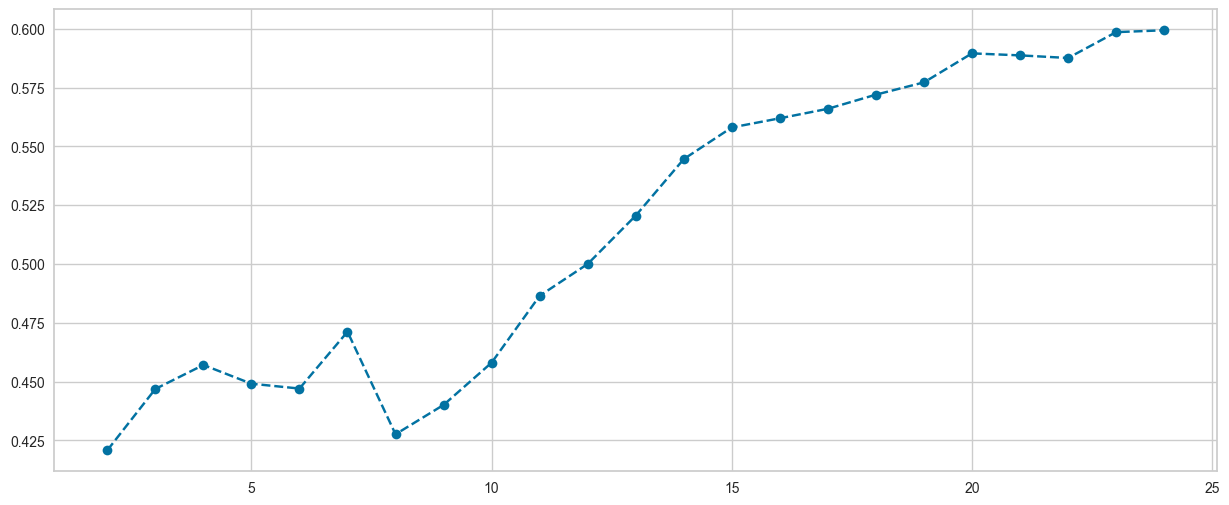

In [51]:
plt.plot(clusters, hc_list, linestyle='--', marker='o',color='b')
plt.gcf().set_size_inches(15, 6)

## 7.5 Results

In [52]:
# resalt tree embedding 
df_results= pd.DataFrame(
    {'KMeans':kmeans_list,
     'GMM':gmm_list,
     'HC':hc_list}
   
).T
df_results.columns=clusters
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.441310,0.476024,0.473492,0.458320,0.486431,0.482191,0.454777,0.460294,0.474885,0.489921,0.510367,0.531503,0.555495,0.567586,0.571034,0.578894,0.575395,0.581655,0.593961,0.595311,0.595345,0.605374,0.605658
GMM,0.368608,0.391203,0.407367,0.384282,0.370138,0.339860,0.417404,0.286065,0.412576,0.474920,0.478749,0.441727,0.462957,0.531340,0.545714,0.547754,0.553699,0.549642,0.548054,0.564298,0.546539,0.569038,0.537355
HC,0.420813,0.446875,0.457068,0.449102,0.447046,0.471206,0.427617,0.440089,0.458050,0.486457,0.500001,0.520546,0.544576,0.558031,0.561925,0.565959,0.571963,0.577180,0.589514,0.588663,0.587552,0.598539,0.599329


In [53]:
# 7.6 Results - UMAP
df_results= pd.DataFrame(
    {'KMeans':kmeans_list,
     'GMM':gmm_list,
     'HC':hc_list}
   
).T
df_results.columns=clusters
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.441310,0.476024,0.473492,0.458320,0.486431,0.482191,0.454777,0.460294,0.474885,0.489921,0.510367,0.531503,0.555495,0.567586,0.571034,0.578894,0.575395,0.581655,0.593961,0.595311,0.595345,0.605374,0.605658
GMM,0.368608,0.391203,0.407367,0.384282,0.370138,0.339860,0.417404,0.286065,0.412576,0.474920,0.478749,0.441727,0.462957,0.531340,0.545714,0.547754,0.553699,0.549642,0.548054,0.564298,0.546539,0.569038,0.537355
HC,0.420813,0.446875,0.457068,0.449102,0.447046,0.471206,0.427617,0.440089,0.458050,0.486457,0.500001,0.520546,0.544576,0.558031,0.561925,0.565959,0.571963,0.577180,0.589514,0.588663,0.587552,0.598539,0.599329


In [54]:
# 7.7 Results - TSE  
df_results= pd.DataFrame(
    {'KMeans':kmeans_list,
     'GMM':gmm_list,
     'HC':hc_list}
   
).T
df_results.columns=clusters
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.441310,0.476024,0.473492,0.458320,0.486431,0.482191,0.454777,0.460294,0.474885,0.489921,0.510367,0.531503,0.555495,0.567586,0.571034,0.578894,0.575395,0.581655,0.593961,0.595311,0.595345,0.605374,0.605658
GMM,0.368608,0.391203,0.407367,0.384282,0.370138,0.339860,0.417404,0.286065,0.412576,0.474920,0.478749,0.441727,0.462957,0.531340,0.545714,0.547754,0.553699,0.549642,0.548054,0.564298,0.546539,0.569038,0.537355
HC,0.420813,0.446875,0.457068,0.449102,0.447046,0.471206,0.427617,0.440089,0.458050,0.486457,0.500001,0.520546,0.544576,0.558031,0.561925,0.565959,0.571963,0.577180,0.589514,0.588663,0.587552,0.598539,0.599329


# 8.0 Model Training

## 8.1 Final model


In [55]:
# ## Model Definition
# k = 8
# gmm_model= mx.GaussianMixture(n_components=k)
# ## Model training 
# gmm_model.fit( X )

# ## Model Predict 
# labels = gmm_model.predict( X )

In [56]:
#model definition
k=12
kmeans =c.KMeans(init='random', n_clusters=k, n_init =300, max_iter=300)

#model training
kmeans.fit(X)

#clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [57]:

print('SS value: {}'.format(m.silhouette_score(X,labels, metric='euclidean')))

SS value: 0.5052520632743835


# 9.0 Cluster Anlysis

In [58]:
df9=X.copy()
df9['cluster']=labels


### 9.1 Visualization Inspection

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

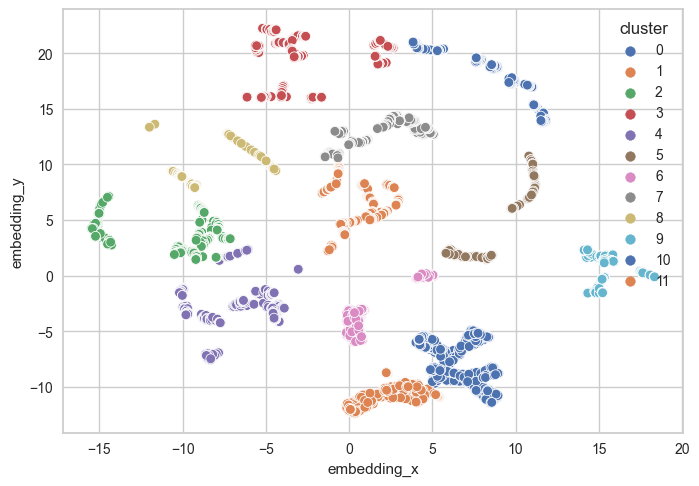

In [59]:
sns.scatterplot(x='embedding_x',y='embedding_y',hue='cluster',data=df9,palette='deep')

## 9.2 Cluster Profile 

In [60]:
df92= df4.copy()
df92['cluster']= labels
df92.head()
#charge dtypes 
df92['recency_days']  = df92['recency_days'].astype(int)
df92['qtde_products'] = df92['qtde_products'].astype(int)
df92['qtde_returns']  = df92['qtde_returns'].astype(int)

# df92['last_training_timestamp']= datetime.now().strftime('%Y-%m-%d %H:%M:%S')


In [61]:
#Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer']=100*(df_cluster['customer_id']/df_cluster['customer_id'].sum() )

#AVG Gross revenue
df_avg_gross_revenue =df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge (df_cluster,df_avg_gross_revenue, how ='inner', on= 'cluster')

#AVG recency days 
df_avg_recency_days = df92[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster= pd.merge(df_cluster,df_avg_recency_days,how ='inner', on= 'cluster')

#AVG invoice_no
df_qtde_products = df92[['qtde_products','cluster']].groupby('cluster').mean().reset_index()
df_cluster=pd.merge (df_cluster,df_qtde_products, how ='inner', on= 'cluster')

#frequency
df_frequency = df92[['frequency','cluster']].groupby('cluster').mean().reset_index()
df_cluster=pd.merge (df_cluster, df_frequency, how ='inner', on= 'cluster')

#returns
df_qtde_returns = df92[['qtde_returns','cluster']].groupby('cluster').mean().reset_index()
df_cluster=pd.merge (df_cluster,df_qtde_returns, how ='inner', on= 'cluster')
df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
0,0,935,16.417910,1914.305380,26.917647,111.802139,0.032212,16.850267
1,1,539,9.464442,8310.360631,8.792208,328.512059,0.124733,103.903525
2,2,586,10.289728,967.371860,76.232082,60.924915,0.652618,7.621160
3,3,472,8.287972,496.684576,255.000000,40.391949,1.023305,2.298729
4,4,633,11.115013,668.844771,33.843602,35.364929,0.853597,2.361769
5,5,344,6.040386,1330.139012,152.476744,64.468023,0.036824,40.904070
6,6,403,7.076383,1874.274020,13.585608,103.062035,0.037516,13.531017
7,7,371,6.514486,666.035337,192.412399,47.832884,1.016173,1.280323
8,8,329,5.776997,742.754316,146.443769,48.924012,0.457426,7.911854
9,9,277,4.863916,906.624801,362.581227,65.126354,1.051473,2.472924


In [62]:
df_cluster.sort_values('gross_revenue',ascending = False)


,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
1,1,539,9.464442,8310.360631,8.792208,328.512059,0.124733,103.903525
0,0,935,16.417910,1914.305380,26.917647,111.802139,0.032212,16.850267
6,6,403,7.076383,1874.274020,13.585608,103.062035,0.037516,13.531017
5,5,344,6.040386,1330.139012,152.476744,64.468023,0.036824,40.904070
2,2,586,10.289728,967.371860,76.232082,60.924915,0.652618,7.621160
9,9,277,4.863916,906.624801,362.581227,65.126354,1.051473,2.472924
10,10,356,6.251097,857.132837,311.974719,63.997191,1.005618,210.370787
11,11,450,7.901668,778.143956,134.557778,67.286667,0.909348,2.420000
8,8,329,5.776997,742.754316,146.443769,48.924012,0.457426,7.911854
4,4,633,11.115013,668.844771,33.843602,35.364929,0.853597,2.361769


In [63]:
# 2 Cluster Insiders
# 7 Cluster more Products 
# 5 Cluster Spend Money 
# 4 cluster even more Products 
# 5 Cluster Less Days
# 3 Cluster less 1k  
# 0 Cluster Stop Returners
# 1 Cluster More Buy 


### Cluster 01 ( Candidato á Insider)

-Numero de Customer :6 (0.14% do customers)

-Recencia em media :7 dias 

-COmpras em medias :89 compras 

-Receita media de :$ 182.182,00 dolares

### Cluster 02 

-Numero de Customer :31 (0.71% do customers)

-Recencia em media :14 dias

-COmpras em medias :53 compras

-Receita media de :$ 40.543,52 dolares


### Cluster 03

-Numero de Customer :4.335 (99% do customers)

-Recencia em media :92 dias

-COmpras em medias :5 comprasm

-Receita media de :$ 1.372,57 dolares


# 10.0 Analise Exploratoria de Dados 

In [64]:
df10=df92.copy()

# 11.0 Deploy to production

In [65]:
df10.dtypes

customer_id        int64
gross_revenue    float64
recency_days       int64
qtde_products      int64
frequency        float64
qtde_returns       int64
cluster            int32
dtype: object

In [66]:
# #database conection
conn =sqlite3.connect('insiders_db.sqlite_3') 

# #drop table
# query_create_insiders_="""
#     DROP TABLE insiders
# """
#create table 

query_create_insiders_="""
    CREATE TABLE insiders (
       customer_id     INTEGER,
       gross_revenue    REAL,
       recency_days    INTEGER,
       qtde_products   INTEGER,
       frequency       REAL,
       qtde_returns    INTEGER,
       cluster         INTEGER

    )
 """
# colocando os dados no banco 


conn.execute(query_create_insiders_)

In [59]:
#conectando com o banco criado  
conn = create_engine('sqlite:////home/leticia/Documentos/comunidade_ds/pa_05/src/models/insiders_db.sqlite_3')
# #Colocando dados no banco 
df92.to_sql('insiders2',con=conn, if_exists='append',index=False)

5695